# MESQUAL 102: Advanced Data Fetching Techniques

## Introduction

Building on the StudyManager fundamentals, this notebook demonstrates MESQUAL's advanced data fetching and transformation capabilities. These techniques significantly streamline multi-scenario analysis by leveraging pandas' power while abstracting away common boilerplate code.

MESQUAL's data handling utilities provide efficient ways to:
- Work with multi-index DataFrames from scenario and comparison collections
- Filter data using model properties
- Aggregate data across complex dimensions
- Combine scenarios and comparisons in unified analyses

## Setup
First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

Running locally, let's continue.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let’s go!")

✅ Environment ready. Let’s go!


In [3]:
import plotly.express as px

from mesqual.utils.pandas_utils import flatten_df, prepend_model_prop_levels, filter_by_model_query
from mesqual.utils.plotly_utils.plotly_theme import PlotlyTheme
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

configure_clean_output_for_jupyter_notebook()
PlotlyTheme().apply()
renderer = ConditionalRenderer()

In [4]:
# Same study setup as in 101, only this time it's from a method so we can re-use it
from studies.study_01_intro_to_mesqual.scripts.setup_study_manager import get_scigrid_de_study_manager

study = get_scigrid_de_study_manager()


## Working with Multi-Index DataFrames

Fetching data across multiple scenarios naturally creates multi-index DataFrames. Let's examine and transform these structures:

### Calculating Averages Per Scenario Comparison

In [5]:
df_price_change = study.comp.fetch('buses_t.marginal_price')
df_price_change_mean = df_price_change.mean().unstack('dataset')
print(df_price_change_mean)

dataset    solar_150 vs base  solar_200 vs base  wind_150 vs base  wind_200 vs base
Bus                                                                                
1                       0.21               0.23             -6.64             -7.29
10                      0.25               0.21             -6.22             -8.21
100                    -0.71              -1.28             -1.50             -3.40
100_220kV              -0.72              -1.29             -1.50             -3.41
101                     0.14               0.10             -6.12             -7.51
...                      ...                ...               ...               ...
96_220kV               -0.17              -0.41             -4.03             -4.81
97                     -0.69              -1.24             -1.39             -2.56
98                      0.17               0.13             -6.16             -7.61
99                     -0.71              -1.28             -1.32           

The result is a DataFrame showing the average price change per bus for each scenario comparison.

### Combining Scenarios and Comparisons

To analyze both raw values and deltas in one operation:

In [6]:
df_price_all = study.scen_comp.fetch('buses_t.marginal_price')
print(df_price_all.head())

type                scenario               ...       comparison               
dataset                 base               ... wind_200 vs base               
Bus                        1    10    100  ...               98    99 99_220kV
snapshot                                   ...                                
2011-01-01 00:00:00    -0.44  5.77  23.12  ...            -1.82  0.10     0.11
2011-01-01 01:00:00    -0.58  6.10  22.53  ...            -2.02 -0.81    -0.82
2011-01-01 02:00:00    -0.58  6.07  22.11  ...            -2.01 -2.26    -2.26
2011-01-01 03:00:00    -0.60  6.14  21.50  ...            -2.15 -3.48    -3.48
2011-01-01 04:00:00    -0.61  6.16  20.39  ...            -2.15 -5.06    -5.05

[5 rows x 5265 columns]


This DataFrame contains both the scenario data and comparison data, distinguished by the 'type' level in the MultiIndex.

### Unified Analysis

We can perform operations on this unified structure:

In [7]:
df_price_all_mean = df_price_all.mean().droplevel('type').unstack('dataset').sort_index(axis=1)
print(df_price_all_mean)

dataset     base  solar_150  solar_150 vs base  ...  wind_150 vs base  wind_200  wind_200 vs base
Bus                                             ...                                              
1           7.68       7.89               0.21  ...             -6.64      0.38             -7.29
10         10.99      11.25               0.25  ...             -6.22      2.78             -8.21
100        21.88      21.17              -0.71  ...             -1.50     18.48             -3.40
100_220kV  21.98      21.26              -0.72  ...             -1.50     18.57             -3.41
101         8.25       8.39               0.14  ...             -6.12      0.74             -7.51
...          ...        ...                ...  ...               ...       ...               ...
96_220kV   13.21      13.04              -0.17  ...             -4.03      8.40             -4.81
97         21.29      20.59              -0.69  ...             -1.39     18.73             -2.56
98          8.58    

This creates a table with average prices and deltas side by side, sorted alphabetically by dataset name.

## Integrating Model Data with Time Series

A powerful MESQUAL capability is the integration of static model data with time series data.

### Accessing Model Data

In [8]:
buses_model_df = study.scen.get_dataset('base').fetch('buses')
print(buses_model_df)

           v_nom type      x  ...                                      wkt_srid_4326                   location control_area
Bus                           ...                                                                                           
1          220.0        9.52  ...  SRID=4326;POINT(9.52257596986262 52.3604090557...   POINT (9.52258 52.36041)     TenneTDE
2          380.0        9.11  ...  SRID=4326;POINT(9.11321007472722 52.5438533223...   POINT (9.11321 52.54385)     TenneTDE
3          380.0        9.39  ...  SRID=4326;POINT(9.38974509624863 52.0263130660...   POINT (9.38975 52.02631)     TenneTDE
4          380.0        9.13  ...  SRID=4326;POINT(9.12526570294975 52.5382640870...   POINT (9.12527 52.53826)     TenneTDE
5          380.0       10.37  ...  SRID=4326;POINT(10.3662749375017 52.2846467462...  POINT (10.36627 52.28465)     TenneTDE
...          ...  ...    ...  ...                                                ...                        ...          ...


### Filtering by Model Properties

Let's filter our time series to include only high voltage buses (v_nom >= 380 kV):

In [9]:
filtered_price_df = filter_by_model_query(df_price_all, buses_model_df, 'v_nom >= 380')
print(filtered_price_df.head())

type                scenario               ...       comparison            
dataset                 base               ... wind_200 vs base            
Bus                       10    100   101  ...               97    98    99
snapshot                                   ...                             
2011-01-01 00:00:00     5.77  23.12  1.36  ...            -1.10 -1.82  0.10
2011-01-01 01:00:00     6.10  22.53  1.35  ...             0.51 -2.02 -0.81
2011-01-01 02:00:00     6.07  22.11  1.34  ...            -1.21 -2.01 -2.26
2011-01-01 03:00:00     6.14  21.50  1.38  ...            -2.35 -2.15 -3.48
2011-01-01 04:00:00     6.16  20.39  1.41  ...            -5.12 -2.15 -5.06

[5 rows x 2592 columns]


The `filter_by_model_query` utility applies pandas query syntax to filter time series based on model properties.

### Prepending Model Properties

We can add model properties as additional index levels:

In [10]:
price_with_control_area = prepend_model_prop_levels(filtered_price_df, buses_model_df, 'control_area')
print(price_with_control_area.head())

control_area         50Hertz  Amprion  50Hertz  ...         TenneTDE          50Hertz          Amprion
type                scenario scenario scenario  ...       comparison       comparison       comparison
dataset                 base     base     base  ... wind_200 vs base wind_200 vs base wind_200 vs base
Bus                       10      100      101  ...               97               98               99
snapshot                                        ...                                                   
2011-01-01 00:00:00     5.77    23.12     1.36  ...            -1.10            -1.82             0.10
2011-01-01 01:00:00     6.10    22.53     1.35  ...             0.51            -2.02            -0.81
2011-01-01 02:00:00     6.07    22.11     1.34  ...            -1.21            -2.01            -2.26
2011-01-01 03:00:00     6.14    21.50     1.38  ...            -2.35            -2.15            -3.48
2011-01-01 04:00:00     6.16    20.39     1.41  ...            -5.12     

This operation adds the 'control_area' property from the bus model as a new level in our multi-index DataFrame.

### Aggregating by Model Properties

Now we can efficiently aggregate by control area:

In [11]:
price_by_control_area = price_with_control_area.mean().groupby(level=['control_area', 'dataset']).mean().unstack('control_area')
print(price_by_control_area)

control_area       50Hertz  Amprion  TenneTDE  TransnetBW
dataset                                                  
base                 11.66    18.88     15.09       23.33
solar_150            11.63    18.26     14.64       22.74
solar_150 vs base    -0.03    -0.63     -0.45       -0.59
solar_200            11.45    17.79     14.29       22.18
solar_200 vs base    -0.21    -1.09     -0.80       -1.16
wind_150              7.09    17.08     12.08       22.66
wind_150 vs base     -4.57    -1.81     -3.01       -0.67
wind_200              4.77    15.64     10.42       21.04
wind_200 vs base     -6.89    -3.24     -4.67       -2.29


## Sophisticated Visualization Example

Let's demonstrate these techniques with a more sophisticated visualization. We'll create a boxplot showing the distribution of hourly prices by control area and scenario:

/Users/helgeesch/Documents/repositories/mescal-vanilla-studies/venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/Users/helgeesch/Documents/repositories/mescal-vanilla-studies/venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/Users/helgeesch/Documents/repositories/mescal-vanilla-studies/venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/Users/helgeesch/Documents/repositories/mescal-vanilla-studies/venv/lib/python3.12/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, se

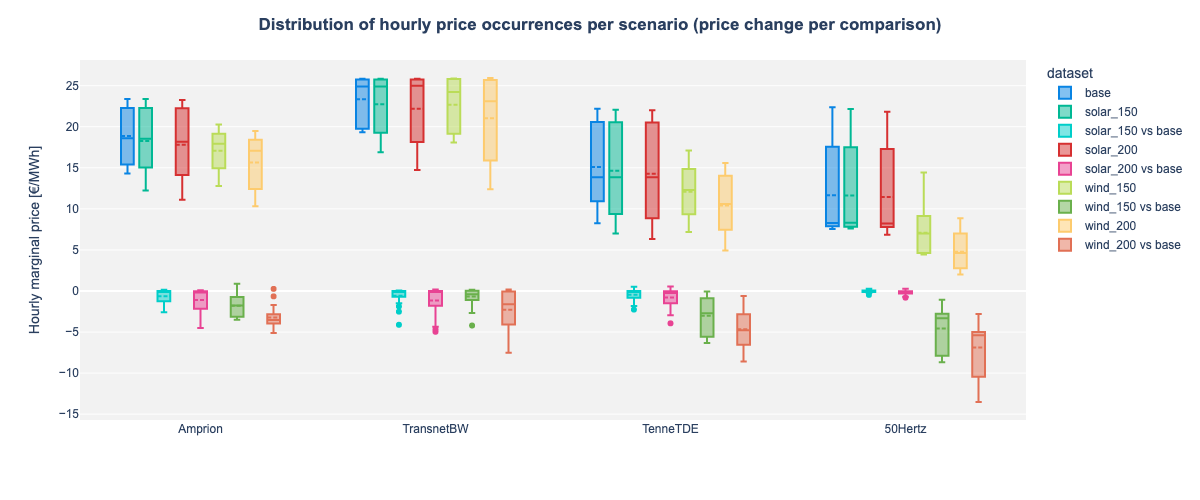

In [12]:
buses_model_df = study.scen.get_dataset('base').fetch('buses')
data = study.scen_comp.fetch('buses_t.marginal_price')
data = filter_by_model_query(data, buses_model_df, query='v_nom >= 380')
data = prepend_model_prop_levels(data, buses_model_df, 'control_area')
data = data.T.groupby(level=['dataset', 'control_area']).mean().T
data_flat = flatten_df(data)
fig = px.box(
    data_frame=data_flat,
    x='control_area',
    color='dataset',
    y='value',
    category_orders={'control_area': ['Amprion', 'TransnetBW', 'TenneTDE', '50Hertz']},
    labels={'value': 'Hourly marginal price [€/MWh]'},
)
fig.update_traces(boxmean=True)
fig.update_layout(title='<b>Distribution of hourly price occurrences per scenario (price change per comparison)</b>', width=1200)
fig.update_xaxes(title=None)

renderer.show_plotly(fig)

## Advanced Transformation Pipeline

Let's trace through a complete data transformation pipeline that demonstrates MESQUAL's efficiency:

In [13]:
# Start with raw data
df_raw = study.scen_comp.fetch('buses_t.marginal_price')

# Filter to high voltage buses
buses_model_df = study.scen.get_dataset('base').fetch('buses')
df_filtered = filter_by_model_query(df_raw, buses_model_df, 'v_nom >= 380')

# Add control area information
df_with_areas = prepend_model_prop_levels(df_filtered, buses_model_df, 'control_area')

# Calculate hourly area prices
hourly_area_prices = df_with_areas.T.groupby(['dataset', 'control_area']).mean().T.unstack()

# Reshape for analysis
area_price_stats = hourly_area_prices.groupby(['dataset', 'control_area']).agg(['mean', 'std', 'min', 'max'])

print(area_price_stats)

                                 mean   std    min    max
dataset           control_area                           
base              50Hertz       11.66  4.90   7.54  22.37
                  Amprion       18.88  3.17  14.31  23.37
                  TenneTDE      15.09  4.93   8.25  22.19
                  TransnetBW    23.33  2.80  19.34  25.85
solar_150         50Hertz       11.63  4.88   7.62  22.17
                  Amprion       18.26  3.83  12.23  23.38
                  TenneTDE      14.64  5.38   6.99  22.07
                  TransnetBW    22.74  3.43  16.90  25.85
solar_150 vs base 50Hertz       -0.03  0.17  -0.48   0.26
                  Amprion       -0.63  0.92  -2.59   0.15
                  TenneTDE      -0.45  0.76  -2.27   0.51
                  TransnetBW    -0.59  1.02  -4.12   0.07
solar_200         50Hertz       11.45  4.87   6.85  21.82
                  Amprion       17.79  4.25  11.10  23.27
                  TenneTDE      14.29  5.63   6.32  22.00
              

What would normally take dozens of lines of data manipulation code is condensed into a few expressive operations that maintain the relationships between different types of data.

## Key Takeaways

- **Unified Analysis**: Work with scenarios and comparisons in the same analytical framework
- **Model and Time-Series Data Fetching**: Unified framework for fetching model and time-series data
- **Useful Integration Utilities**: MESQUAL provides tools like `filter_by_model_query` and `prepend_model_prop_levels` that efficiently establish relationships between model properties and time series data and provide frequently needed filtering and property mapping features

These capabilities make MESQUAL particularly powerful for complex multi-scenario analyses that would otherwise require extensive custom code.